# Baseline with channel format + log loss

In [1]:
# ideas: map-based, player count based, logreg, peterx's stuff
import pandas as pd
from sklearn.metrics import roc_auc_score, log_loss

map_data = pd.read_csv('G:/datasets/csgo/csgo_rounds_dust2.csv', usecols=['RoundNum', 'WinningSide'])
map_baseline = map_data.groupby('WinningSide').agg({'RoundNum': 'count'})
map_baseline = map_baseline / map_baseline.sum(axis=0)
map_baseline

,RoundNum
WinningSide,
CT,0.474391
T,0.525609


In [2]:
import numpy as np

print(roc_auc_score(map_data['WinningSide'] == 'CT', np.zeros(map_data.shape[0])))
print(log_loss(map_data['WinningSide'] == 'CT', np.zeros(map_data.shape[0])))
del map_data

0.5
16.38489957117866


In [3]:
# player count based
import pandas as pd

player_data = pd.read_csv('G:/datasets/csgo/csgo_playerframes_dust2.csv',
                          names=['MatchId',
                              'MapName',
                              'RoundNum',
                              'Tick',
                              'Second',
                              'PlayerId',
                              'PlayerSteamId',
                              'TeamId',
                              'Side',
                              'X',
                              'Y',
                              'Z',
                              'ViewX',
                              'ViewY',
                              'AreaId',
                              'Hp',
                              'Armor',
                              'IsAlive',
                              'IsFlashed',
                              'IsAirborne',
                              'IsDucking',
                              'IsScoped',
                              'IsWalking',
                              'EqValue',
                              'HasHelmet',
                              'HasDefuse',
                              'DistToBombsiteA',
                              'DistToBombsiteB',
                              'Created',
                              'Updated'],
                          usecols=['MatchId', 'RoundNum', 'Tick', 'Side', 'IsAlive'])
player_data['IsAlive'] = player_data['IsAlive'].astype(int)
results = pd.read_csv('G:/datasets/csgo/csgo_rounds_dust2.csv', usecols=['MatchId', 'RoundNum', 'WinningSide'])
player_data = pd.merge(player_data, results, on=['MatchId', 'RoundNum'])
del results
player_data['WinningSide'] = (player_data['WinningSide'] == 'CT').astype(int)
player_data = player_data.groupby(['MatchId',
                                       'RoundNum',
                                       'Side',
                                       'Tick',
                                      ],
                                      as_index=False).agg({'IsAlive': 'sum', 'WinningSide': 'max'})
player_data

,MatchId,RoundNum,Side,Tick,IsAlive,WinningSide
0,4,1,CT,15257,5,1
1,4,1,CT,15290,5,1
2,4,1,CT,15323,5,1
3,4,1,CT,15356,5,1
4,4,1,CT,15389,5,1
...,...,...,...,...,...,...
2131902,1892,22,T,306530,1,1
2131903,1892,22,T,306596,1,1
2131904,1892,22,T,306662,1,1
2131905,1892,22,T,306728,1,1


In [4]:
pivoted = player_data.pivot_table(index=['MatchId', 'RoundNum', 'Tick'], values=['IsAlive'], columns=['Side'])
pivoted['Winner'] = player_data.groupby(['MatchId', 'RoundNum', 'Tick']).agg({'WinningSide': 'max'})['WinningSide']
pivoted

IsAlive      Winner
Side                         CT    T       
MatchId RoundNum Tick                      
4       1        15257      5.0  5.0      1
                 15290      5.0  5.0      1
                 15323      5.0  5.0      1
                 15356      5.0  5.0      1
                 15389      5.0  5.0      1
...                         ...  ...    ...
1892    22       306530     3.0  1.0      1
                 306596     3.0  1.0      1
                 306662     3.0  1.0      1
                 306728     3.0  1.0      1
                 306794     3.0  1.0      1

[1069034 rows x 3 columns]

In [5]:
pivoted.index.levels[0]

Int64Index([   4,   15,   21,   26,   28,   29,   37,   38,   41,   47,
            ...
            1676, 1677, 1690, 1693, 1698, 1786, 1799, 1853, 1878, 1892],
           dtype='int64', name='MatchId', length=173)

In [6]:
import numpy as np

mask = np.random.choice(pivoted.index.levels[0], replace=False, size=int(pivoted.index.levels[0].shape[0] * 0.8))
pivoted.reset_index(drop=False, inplace=True)
train, test = pivoted[pivoted['MatchId'].isin(mask)], pivoted[~pivoted['MatchId'].isin(mask)]
print(pivoted.shape[0], train.shape[0], test.shape[0])

1069034 840727 228307


In [7]:
import seaborn as sns

player_baseline = train.groupby([('IsAlive', 'CT'), ('IsAlive', 'T')], as_index=False).agg({('Winner', ''): 'mean'})
player_baseline.columns = ['CT count', 'T count', 'Win probability']
player_baseline_pivoted = player_baseline.pivot('CT count', 'T count', 'Win probability')

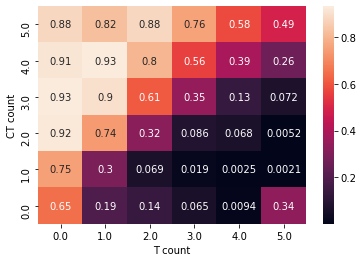

In [8]:
sns.heatmap(data=player_baseline_pivoted[::-1], annot=True);

In [9]:
player_baseline

,CT count,T count,Win probability
0,0.0,0.0,0.647826
1,0.0,1.0,0.191748
2,0.0,2.0,0.139085
3,0.0,3.0,0.064767
4,0.0,4.0,0.009368
5,0.0,5.0,0.337838
6,1.0,0.0,0.749311
7,1.0,1.0,0.295594
8,1.0,2.0,0.068938
9,1.0,3.0,0.018865


In [10]:
test = test[[('IsAlive', 'CT'), ('IsAlive', 'T'), ('Winner', '')]]
test.columns = ['CT count', 'T count', 'truth']

preds = pd.merge(test, player_baseline, on=['CT count', 'T count'])
preds

,CT count,T count,truth,Win probability
0,5.0,2.0,1,0.880390
1,5.0,2.0,1,0.880390
2,5.0,2.0,1,0.880390
3,5.0,2.0,1,0.880390
4,5.0,2.0,1,0.880390
...,...,...,...,...
227909,0.0,5.0,0,0.337838
227910,0.0,5.0,0,0.337838
227911,0.0,5.0,0,0.337838
227912,0.0,5.0,0,0.337838


In [11]:
print(f'AUC: {roc_auc_score(preds["truth"], preds["Win probability"])}')
print(f'Log loss: {log_loss(preds["truth"], preds["Win probability"])}')

AUC: 0.774313639605856
Log loss: 0.550037538559992


In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(preds['truth'], preds['Win probability'] > 0.5)

0.6966311854471423

In [13]:
# WOAH. what is that??? that can't be right

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(preds['truth'], preds['Win probability'])

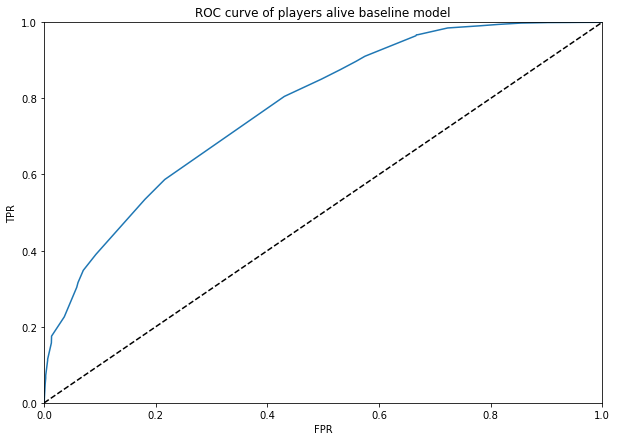

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve of players alive baseline model');

In [15]:
# examine what is up with the weird numbers for 0 ct's

train.columns = ['MatchId', 'RoundNum', 'Tick', 'CT count', 'T count', 'Winner']
train.head()

,MatchId,RoundNum,Tick,CT count,T count,Winner
0,4,1,15257,5.0,5.0,1
1,4,1,15290,5.0,5.0,1
2,4,1,15323,5.0,5.0,1
3,4,1,15356,5.0,5.0,1
4,4,1,15389,5.0,5.0,1


In [16]:
train[(train['CT count'] == 0) & (train['T count'] == 5)]

,MatchId,RoundNum,Tick,CT count,T count,Winner
49746,47,19,300835,0.0,5.0,0
49748,47,19,300901,0.0,5.0,0
49749,47,19,300934,0.0,5.0,0
49750,47,19,300967,0.0,5.0,0
49752,47,19,301033,0.0,5.0,0
...,...,...,...,...,...,...
883717,1506,24,383955,0.0,5.0,0
883718,1506,24,383988,0.0,5.0,0
883721,1506,24,384087,0.0,5.0,0
883722,1506,24,384120,0.0,5.0,0


In [1]:
from csgo_wp.data_transform import transform_data, CSGODataset, transform_multichannel
import warnings
warnings.filterwarnings('ignore')

dataset = CSGODataset(transform=transform_multichannel)

Reading transformed data...

Done!


In [2]:
print(dataset.data.shape)

torch.Size([409641, 6, 5, 5])


In [3]:
val_dataset = CSGODataset(transform=transform_multichannel, dataset_split='val')
test_dataset = CSGODataset(transform=transform_multichannel, dataset_split='test')

Reading transformed data...

Done!
Reading transformed data...

Done!


In [4]:
print(val_dataset.data.shape)
print(test_dataset.data.shape)

torch.Size([175042, 6, 5, 5])
torch.Size([164186, 6, 5, 5])


In [5]:
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, accuracy_score

AUC:  0.7447931723335289
Log loss:  0.5782255539325183
Accuracy:  0.6820820146022097


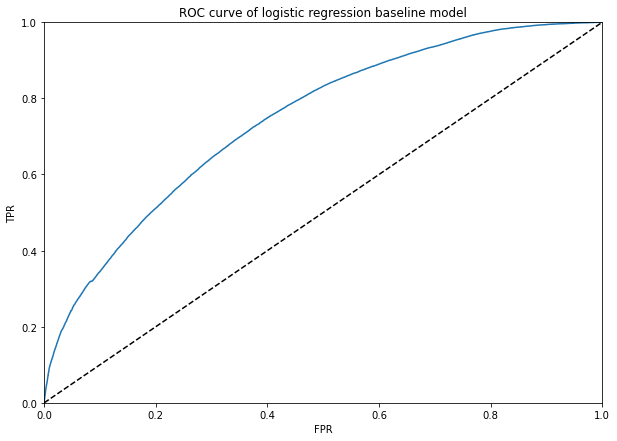

In [7]:
import torch

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=13)
lr.fit(dataset.data.view(-1, 150), dataset.targets)
preds = lr.predict_proba(val_dataset.data.view(-1, 150))

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(val_dataset.targets, preds[:, 1])

print('AUC: ', roc_auc_score(val_dataset.targets, preds[:, 1]))
print('Log loss: ', log_loss(val_dataset.targets, preds[:, 1]))
print('Accuracy: ', accuracy_score(val_dataset.targets, preds[:, 1] > 0.5))

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve of logistic regression baseline model');

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 65.3min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 148.7min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed: 170.5min finished


AUC:  0.788196669273322
Log loss:  0.5223852725918076
Accuracy:  0.7062590692519509


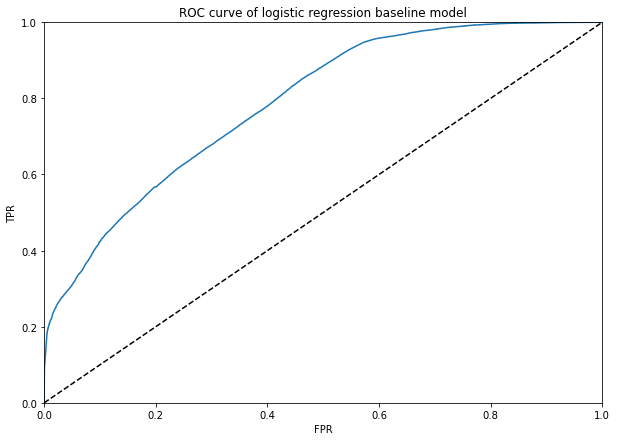

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

params = {'C': loguniform(1e-3, 1e1),
          'l1_ratio': uniform(),
          }

lr = LogisticRegression(random_state=13, solver='saga', penalty='elasticnet')

cv = RandomizedSearchCV(lr, params, random_state=3, n_iter=100, n_jobs=6, verbose=1, scoring='roc_auc')
cv.fit(dataset.data.view(-1, 150), dataset.targets)

preds = cv.best_estimator_.predict_proba(val_dataset.data.view(-1, 150))

fpr, tpr, _ = roc_curve(val_dataset.targets, preds[:, 1])

print('AUC: ', roc_auc_score(val_dataset.targets, preds[:, 1]))
print('Log loss: ', log_loss(val_dataset.targets, preds[:, 1]))
print('Accuracy: ', accuracy_score(val_dataset.targets, preds[:, 1] > 0.5))

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve of logistic regression baseline model');

In [10]:
cv.best_estimator_

LogisticRegression(C=7.263959337796386, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.7510273073183793, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=13, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.5min finished


AUC:  0.7897245563325281
Log loss:  0.5182551794691311
Accuracy:  0.7085956513293953


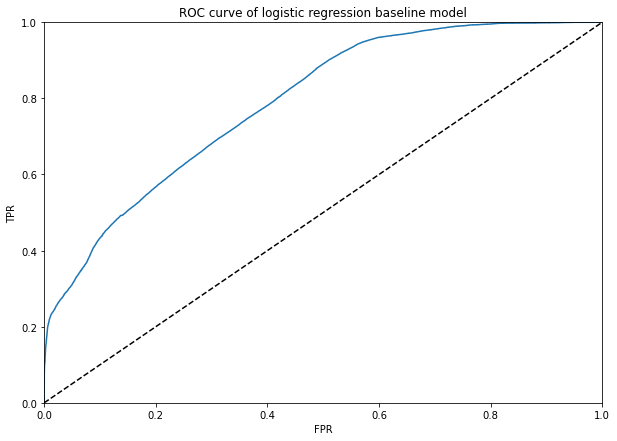

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

params = {'C': loguniform(1e-3, 1e1),
          'l1_ratio': uniform(),
          }

scaler = StandardScaler()
thresh = VarianceThreshold()  # remove constant features

thresh.fit(dataset.data.view(-1, 150))
scaler.fit(thresh.transform(dataset.data.view(-1, 150)))

lr = LogisticRegression(random_state=13, solver='saga', penalty='elasticnet')

cv = RandomizedSearchCV(lr, params, random_state=3, n_iter=100, n_jobs=-1, verbose=1, scoring='roc_auc', pre_dispatch='n_jobs')
cv.fit(scaler.transform(thresh.transform(dataset.data.view(-1, 150))),
       dataset.targets)

preds = cv.best_estimator_.predict_proba(scaler.transform(thresh.transform(val_dataset.data.view(-1, 150))))

fpr, tpr, _ = roc_curve(val_dataset.targets, preds[:, 1])

print('AUC: ', roc_auc_score(val_dataset.targets, preds[:, 1]))
print('Log loss: ', log_loss(val_dataset.targets, preds[:, 1]))
print('Accuracy: ', accuracy_score(val_dataset.targets, preds[:, 1] > 0.5))

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve of logistic regression baseline model');

In [19]:
cv.best_estimator_

LogisticRegression(C=0.0019701290593098237, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.8923931875870925, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=13, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
cv.best_estimator_.score(scaler.transform(thresh.transform(val_dataset.data.view(-1, 150))), val_dataset.targets)

0.7085956513293953

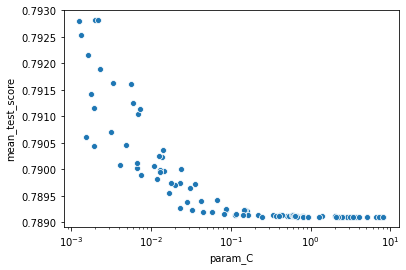

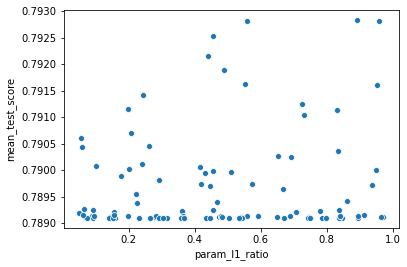

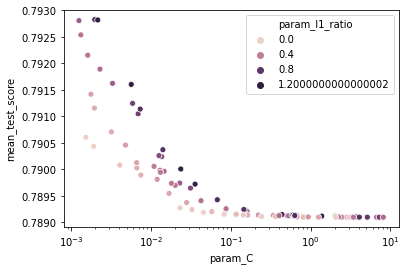

In [13]:
import pandas as pd
import seaborn as sns

results = pd.DataFrame.from_dict(cv.cv_results_)
sns.scatterplot(x='param_C', y='mean_test_score', data=results)
plt.xscale('log')
plt.show()
sns.scatterplot(x='param_l1_ratio', y='mean_test_score', data=results)
plt.show()
sns.scatterplot(x='param_C', y='mean_test_score', hue='param_l1_ratio', data=results)
plt.xscale('log')
plt.show()

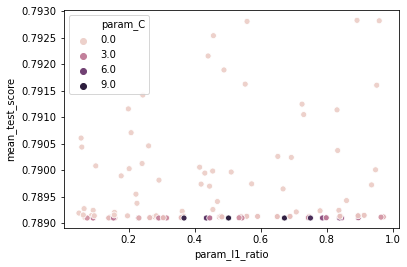

In [14]:
sns.scatterplot(x='param_l1_ratio', y='mean_test_score', hue='param_C', data=results)
plt.show()

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 192 tasks      | elapsed: 18.5min
[Parallel(n_jobs=8)]: Done 442 tasks      | elapsed: 39.1min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 46.5min finished


AUC:  0.7802311496890286
Log loss:  0.5322571431835534
Accuracy:  0.7105380422984198


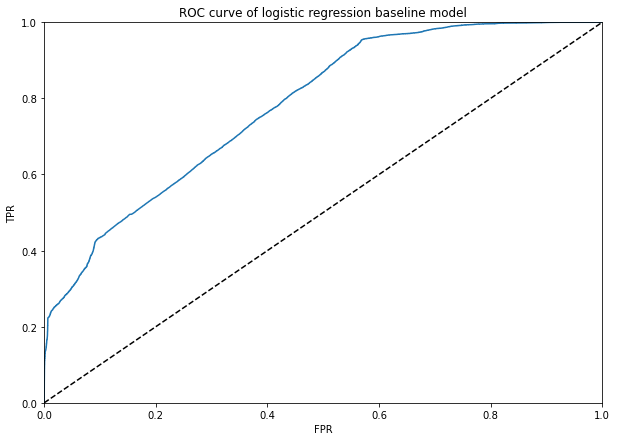

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

params = {'C': loguniform(1e-6, 1e-2),
          }

scaler = StandardScaler()
thresh = VarianceThreshold()  # remove constant features

thresh.fit(dataset.data.view(-1, 150))
scaler.fit(thresh.transform(dataset.data.view(-1, 150)))

lr = LogisticRegression(random_state=13, l1_ratio=1, solver='saga', penalty='elasticnet')

cv = RandomizedSearchCV(lr, params, random_state=3, n_iter=100, n_jobs=8, verbose=1, scoring='roc_auc', pre_dispatch='n_jobs')
cv.fit(scaler.transform(thresh.transform(dataset.data.view(-1, 150))),
       dataset.targets)

preds = cv.best_estimator_.predict_proba(scaler.transform(thresh.transform(val_dataset.data.view(-1, 150))))

fpr, tpr, _ = roc_curve(val_dataset.targets, preds[:, 1])

print('AUC: ', roc_auc_score(val_dataset.targets, preds[:, 1]))
print('Log loss: ', log_loss(val_dataset.targets, preds[:, 1]))
print('Accuracy: ', accuracy_score(val_dataset.targets, preds[:, 1] > 0.5))

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve of logistic regression baseline model');

In [16]:
cv.best_estimator_

LogisticRegression(C=0.00015086763143259878, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=1,
                   max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='elasticnet', random_state=13, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

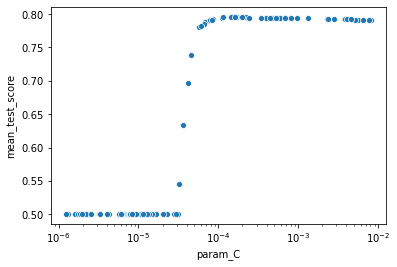

In [17]:
results = pd.DataFrame.from_dict(cv.cv_results_)
sns.scatterplot(x='param_C', y='mean_test_score', data=results)
plt.xscale('log')
plt.show()